# LangGraph MultiModel Setup, Init, Tests, Model Exploration

We simulate three agents with distinct character: a creative agent, logical agent, and critical agent to test langgrophs multi-model broad capabilities.

## LangGraph101 - like a multi-agent, tool-using-memory aware sate machine

**Key Concepts:**
- Each node (an llm or function) is a step
- Edges decide where to go next
- A shared state is passed and updates at each step (a dict)
- The graph runs until halting condition

**For example**
1. You give it initial state: {"messages": [User message]}
2. LangGraph calls your broadcast_router() → ["creative", "logical", "critic"]
3. It runs all 3 nodes in parallel (each reads state, adds its response)
4. The graph checks the finish condition
5. If not done, it asks: which nodes next?
6. Loops again or stops

In [1]:
import os

from langgraph.graph import StateGraph
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.runnables import Runnable

from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
api_key = os.environ["OPENROUTER_API_KEY"]

In [3]:
openrouter_client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=api_key,
)

Wrap openrouter into a langgraph compatible agent

In [4]:
def make_openrouter_agent(model: str, role_name: str, prompt_prefix: str = ""):
    def _run(state: dict) -> dict:
        history = state.get("messages", [])
        prompt = (
            prompt_prefix + "\n" + history[-1].content if history else "Let's start."
        )

        print(f"🟡 Sending to {role_name} ({model}) with prompt:\n{prompt}\n")

        try:
            response = openrouter_client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
            )
            reply = response.choices[0].message.content
            print(f"🟢 {role_name} responded:\n{reply}\n")
        except Exception as e:
            reply = f"[ERROR] {e}"
            print(f"🔴 {role_name} failed: {e}\n")

        history.append(AIMessage(content=f"[{role_name}] {reply}"))
        return {"messages": history}

    return _run

Define agent nodes

In [5]:
nodes = {
    "creative": make_openrouter_agent(
        model="mistralai/mistral-7b-instruct",
        role_name="CreativeAgent",
        prompt_prefix="Respond creatively and freely.",
    ),
    "logical": make_openrouter_agent(
        model="deepseek/deepseek-r1-0528-qwen3-8b",
        role_name="LogicalAgent",
        prompt_prefix="Be analytical, precise, and structured.",
    ),
    "critic": make_openrouter_agent(
        model="google/gemma-2-9b-it",
        role_name="CriticAgent",
        prompt_prefix="Critique the last idea rationally and constructively.",
    ),
}

In [6]:
# Shared state type
class GraphState(dict):
    pass

## Graph 1: Broadcast Messages to All Agents

In [13]:
def broadcast_router(state):
    print("📢 Router function called")
    return {"__branch__": ["creative", "logical", "critic"]}

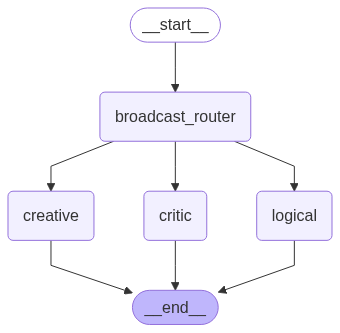

In [19]:
# Build the graph
graph1 = StateGraph(GraphState)

for name, func in nodes.items():
    graph1.add_node(name, func)

graph1.add_node("broadcast_router", broadcast_router)
graph1.set_entry_point("broadcast_router")

graph1.add_edge("broadcast_router", "creative")
graph1.add_edge("broadcast_router", "logical")
graph1.add_edge("broadcast_router", "critic")

# end node to finalize the conversation
for name in nodes.keys():
    graph1.add_edge(name, "__end__")

# # or we could loop back instead of ending
# graph.add_edge("creative", broadcast_router)
# graph.add_edge("logical", broadcast_router)
# graph.add_edge("critic", broadcast_router)

compiled_graph1 = graph1.compile()
compiled_graph1

So in this graph the entry point is a user message that goes to broadcast_router, which then sends the message to all agents and then ends.

Test it

In [20]:
# Initial state with a human message
initial_state = {
    "messages": [HumanMessage(content="Design a chair that helps people think better.")]
}

In [21]:
# Run the graph
final_state = compiled_graph1.invoke(initial_state)
print("Final state:", final_state)

📢 Router function called
🟡 Sending to CreativeAgent (mistralai/mistral-7b-instruct) with prompt:
Let's start.

🟡 Sending to CriticAgent (google/gemma-2-9b-it) with prompt:
Let's start.

🟡 Sending to LogicalAgent (deepseek/deepseek-r1-0528-qwen3-8b) with prompt:
Let's start.

🟢 CriticAgent responded:
Great! What can I do for you today? 😊

Are you looking to:

* **Chat about a specific topic?**

* **Get help with a task?**
* **Write something creative?**
* **Just have a friendly conversation?**

Let me know and we can get started!  ✨


🟢 CreativeAgent responded:
 Of course! I'm here to help. What would you like to know or discuss today? Whether it's about a specific topic or a question you have in mind, feel free to ask, and I'll do my best to provide a useful response. 😊

🟢 LogicalAgent responded:
Hello! It sounds like you're ready to dive in. To make the most of this, I need a little more context—what would you like to start doing or discussing? 😊

For example:
- Do you have a specific